## Object Detection using InceptionResNet

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#### Load data

In [2]:
df = pd.read_csv('labels.csv')
df.head()

,filepath,xmin,xmax,ymin,ymax
0,../images/01.xml,79,267,111,156
1,../images/02.xml,508,926,343,503
2,../images/03.xml,68,335,94,152
3,../images/04.xml,113,208,86,110
4,../images/05.xml,40,164,128,192


In [3]:
# Get file path for a given XML file
def getFilePath(filename):
    # Extract the name of the corresponding image file and create a file path for it
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('../images', filename_image)
    # Return the file path for the image file
    return filepath_image

# Get list of image file paths
image_paths = list(df['filepath'].apply(getFilePath))


#### Data Preprocessing

In [4]:
# Get labels xmin, xmax, ymin, ymax
labels = df.iloc[:,1:].values

In [5]:
labels

array([[ 79, 267, 111, 156],
       [508, 926, 343, 503],
       [ 68, 335,  94, 152],
       ...,
       [ 90, 213,  98, 128],
       [ 31, 232,  47, 141],
       [ 32, 239,  60, 113]])

In [6]:
data = []
output = []

# Enumerate over image paths and their labels
for i, (image_path, label) in enumerate(zip(image_paths, labels)):
    
    # Read image and get dimensions
    img_array = cv2.imread(image_path)
    h, w, d = img_array.shape

    # Preprocess the image
    load_image = load_img(image_path, target_size=(224, 224))
    load_img_array = img_to_array(load_image)
    norm_load_img_array = load_img_array / 255.0 # Normalize pixel values

    # Normalize label coordinates
    xmin, xmax, ymin, ymax = label
    nxmin, nxmax = xmin / w, xmax / w
    nymin, nymax = ymin / h, ymax / h
    norm_label = (nxmin, nxmax, nymin, nymax) # Normalized output

    # Append the preprocessed image and label to the data and output lists
    data.append(norm_load_img_array)
    output.append(norm_label)


#### Train tet split

In [7]:
# Get target and feature variables
X = np.array(data, dtype=np.float32)
y = np.array(output, dtype=np.float32)

# Print out shape
X.shape, y.shape

((469, 224, 224, 3), (469, 4))

In [8]:
# Splitting X and y into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Print the shape of each set
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (281, 224, 224, 3) (281, 4)
Validation set shape: (94, 224, 224, 3) (94, 4)
Test set shape: (94, 224, 224, 3) (94, 4)


#### Build Deep Learning Model

In [9]:
# Create a pre-trained Inception-ResNet V2 model without the top layer
inception_resnet = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the pre-trained model's weights
inception_resnet.trainable = False

# Define custom classification layers to be added on top of the pre-trained model
x = inception_resnet.output
x = Flatten()(x)
x = Dense(640, activation="relu")(x)
x = Dense(320, activation="relu")(x)
x = Dense(4, activation="sigmoid")(x)

# Create a new model that includes both the pre-trained model and the custom classification layers
model = Model(inputs=inception_resnet.inputs, outputs=x)

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-03-18 16:29:53.045158: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-18 16:29:53.045295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# Compile Model
model.compile(loss="mse",
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

#### Train Model

In [11]:
# Train the model
history = model.fit(X_train,
                    y_train,
                    batch_size=10,
                    epochs=100,
                    validation_data=(X_val, y_val))

Epoch 1/100


2023-03-18 16:30:01.728115: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-18 16:30:05.806705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - ETA: 0s - loss: 0.1513

2023-03-18 16:30:16.866125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 25s 610ms/step - loss: 0.1513 - val_loss: 0.1342
Epoch 2/100
29/29 [==============================] - 4s 146ms/step - loss: 0.1221 - val_loss: 0.1381
Epoch 3/100
29/29 [==============================] - 5s 171ms/step - loss: 0.1206 - val_loss: 0.1218
Epoch 4/100
29/29 [==============================] - 3s 122ms/step - loss: 0.1114 - val_loss: 0.1089
Epoch 5/100
29/29 [==============================] - 4s 129ms/step - loss: 0.1099 - val_loss: 0.1157
Epoch 6/100
29/29 [==============================] - 4s 122ms/step - loss: 0.1032 - val_loss: 0.0956
Epoch 7/100
29/29 [==============================] - 4s 123ms/step - loss: 0.0887 - val_loss: 0.0855
Epoch 8/100
29/29 [==============================] - 4s 123ms/step - loss: 0.0783 - val_loss: 0.0826
Epoch 9/100
29/29 [==============================] - 4s 130ms/step - loss: 0.0759 - val_loss: 0.0830
Epoch 10/100
29/29 [==============================] - 4s 122ms/step - loss: 0.0724 - val_loss: 0.0818


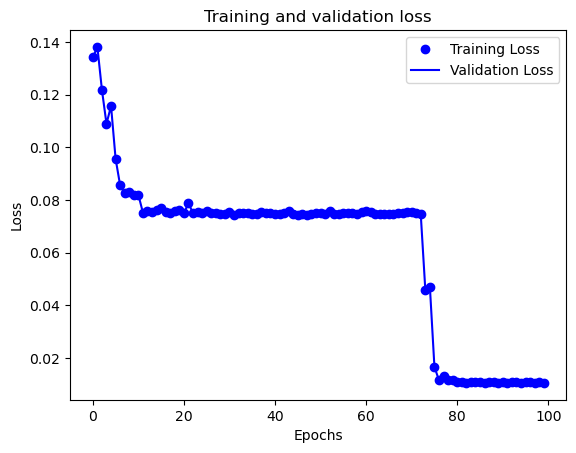

In [12]:
epochs = range(0, len(history.history['loss']))
plt.plot(epochs, history.history['val_loss'], "bo", label="Training Loss")
plt.plot(epochs, history.history['val_loss'], "b", label="Validation Loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Continue Training

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the filepath for the checkpoint file
filepath = "./models/object_detection.h5"

# Create a ModelCheckpoint callback that saves the best model based on validation loss
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

In [17]:
history = model.fit(X_train,
                    y_train,
                    batch_size=10,
                    initial_epoch=100,
                    epochs=200,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint])

Epoch 101/200
29/29 [==============================] - ETA: 0s - loss: 1.7746e-04
Epoch 101: val_loss improved from inf to 0.01089, saving model to ./models/object_detection.h5
29/29 [==============================] - 5s 170ms/step - loss: 1.7746e-04 - val_loss: 0.0109
Epoch 102/200
29/29 [==============================] - ETA: 0s - loss: 1.3645e-04
Epoch 102: val_loss improved from 0.01089 to 0.01042, saving model to ./models/object_detection.h5
29/29 [==============================] - 5s 174ms/step - loss: 1.3645e-04 - val_loss: 0.0104
Epoch 103/200
29/29 [==============================] - ETA: 0s - loss: 1.7254e-04
Epoch 103: val_loss did not improve from 0.01042
29/29 [==============================] - 4s 126ms/step - loss: 1.7254e-04 - val_loss: 0.0108
Epoch 104/200
29/29 [==============================] - ETA: 0s - loss: 3.3458e-04
Epoch 104: val_loss did not improve from 0.01042
29/29 [==============================] - 4s 124ms/step - loss: 3.3458e-04 - val_loss: 0.0105
Epoch 10

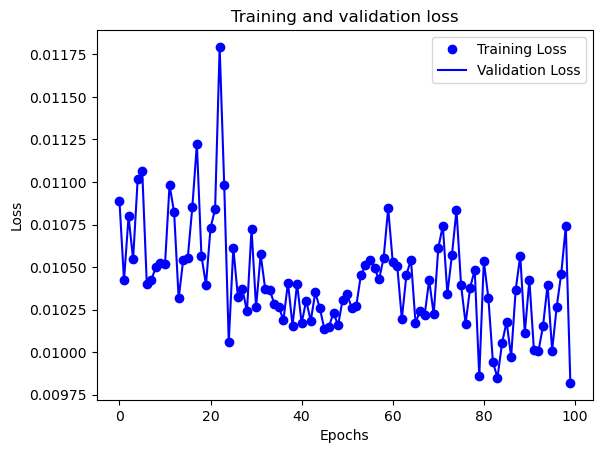

In [18]:
epochs = range(0, len(history.history['loss']))
plt.plot(epochs, history.history['val_loss'], "bo", label="Training Loss")
plt.plot(epochs, history.history['val_loss'], "b", label="Validation Loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()